# Linear Audio Visual Reaction Time Simulation
This notebook use the decision making model by Wang and colleagues to simulate linear audio-visual reaction time task.


In [53]:
from platform import python_version

print(python_version())

3.8.11


## Material and Methods

### Calling Library Fuctions

In [2]:
# LIBRARY
## DDM LIBRARY
import ddm.plot
from ddm import Model, Fittable
from ddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayChain,OverlayNonDecision,OverlayPoissonMixture,BoundCollapsingExponential
from ddm.functions import fit_adjust_model, display_model
from ddm import Sample
from ddm.plot import model_gui
from ddm.models import LossRobustBIC
from ddm.functions import fit_adjust_model, display_model


## LIBRARIES
import numpy as np # vector manipulation
import math  # math functions
import sys
import pandas as pd
from scipy.stats import ttest_ind
# THIS IS FOR PLOTTING
%matplotlib inline
import matplotlib.pyplot as plt # side-stepping mpl backend
import warnings
warnings.filterwarnings("ignore")

# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

import ptitprince as pt
import seaborn as sns

## The Reduced Network Model

The firing rate function, the input-output, 
$$ H(x)=\frac{ax-b}{1-e^{-d(ax-b)}},$$
a=270, b=108 and d=0.154.

In [3]:
def H(x):
    a=270 # Hz/nA
    b=108 # Hz
    d=.154 # seconds
    f=(a*x-b)/(1-np.exp(-d*(a*x-b)))
    return f
x=np.arange(-1,1,0.01)


## Neural Circuit

### Unisensory version
$$ x_{1}=J_{11}S_1-J_{12}S_2+I_{0}+I_{1}+I_{noise,1}$$
$$ x_{2}=J_{22}S_2-J_{21}S_1+I_{0}+I_{2}+I_{noise,1}$$

where the synaptic couplings are $J_{11}=0.2609$, $J_{22}=0.2609$, $J_{12}=0.0497$ and $J_{21}=0.0497$.
$I_{0}=0.3255 nA$ represents external input and $S_1$ and $S_2$ are the auditory activity $A_1$ and $A_2$ or visual activity $V_1$ and $V_2$.
Where 1 is HIT and 2 in MISS


### Multisensory version
TO BE TESTED?
$$ x_{HIT}=J_{11}(A_1+V_1)-J_{12}(A_2+V_2)+I_{0}+I_{1}+I_{noise,1}$$
$$ x_{MISS}=J_{22}(A_2+V_2)-J_{21}(A_1+V_1)+I_{0}+I_{2}+I_{noise,1}$$



In [4]:
def total_synaptic_current(S_1,S_2,I_1,I_2,I_noise_1,I_noise_2):
    # Synaptic coupling
    J_11=0.2609 # nA
    J_22=0.2609 # nA
    J_13=0*0.000497/np.sqrt(2) # nA
    J_24=0*0.000497/np.sqrt(2) # nA
  
    J_12=0.0497 # nA
    J_21=0.0497 # nA
    I_0=0.3255  # nA
    x_1=J_11*S_1-J_12*S_2+I_0+I_1+I_noise_1
    x_2=J_22*S_2-J_21*S_1+I_0+I_2+I_noise_2
    return x_1, x_2


def MULTISENSORY_total_synaptic_current(A_1,A_2,V_1,V_2,I_1,I_2,I_noise_1,I_noise_2):
    # Synaptic coupling
    J_11=0.2609 # nA
    J_22=0.2609 # nA
    J_13=0*0.000497/np.sqrt(2) # nA
    J_24=0*0.000497/np.sqrt(2) # nA
  
    J_12=0.0497 # nA
    J_21=0.0497 # nA
    I_0=0.3255  # nA
    x_1=J_11*(A_1+V_1)-J_12*(A_2+V_2)+I_0+I_1+I_noise_1
    x_2=J_22*(A_2+V_2)-J_21*(A_1+V_1)+I_0+I_2+I_noise_2
    return x_1, x_2



### Background activity
$$ \tau_{AMPA}\frac{d I_{noise,i}(t)}{dt} =-I_{noise,i}(t)+\eta_i(t)\sqrt{\tau_{AMPA}}\sigma_{noise}$$

In [5]:
def Background_Activity(I_noise):
    h=0.1
    sigma_noise=0.02 # nA
    tau_AMPA=2 #ms
    eta_noise=np.random.normal(0,1,1)
    k=0#(-(I_noise)+eta_noise*np.sqrt(tau_AMPA)*sigma_noise)
    I_noise_new=I_noise+h/tau_AMPA*(-(I_noise+h/2*k)+eta_noise
                                *np.sqrt(tau_AMPA)*sigma_noise)
    return I_noise_new

### Network Dynamics
$$ \frac{d S_{i}}{dt} =-\frac{S_{i}}{\tau_S}+(1-S_{i})\gamma H_{i}$$

In [6]:
def Network_Dynamics_VIS(S,x,tau_S=0.1):
    h=0.1/1000 #ms
    gamma=0.641
    tau_S=.100 #s
    k=(-S/tau_S+(1-S)*gamma*H(x)/1)
    S_new=S+h*(-(S+h/2*k)/tau_S+(1-S+h/2*k)*gamma*H(x))
    return S_new

def Network_Dynamics_AUDIO(S,x,tau_S=0.1):
    h=0.1/1000 #ms
    gamma=0.641
    #tau_S=.10 #s
    tau_S=.100 #s
    k=(-S/tau_S+(1-S)*gamma*H(x)/1)
    S_new=S+h*(-(S+h/2*k)/tau_S+(1-S+h/2*k)*gamma*H(x))
    return S_new

def Network_Dynamics_AV(S,x,tau_S=0.1):
    h=0.1/1000 #ms
    gamma=0.641
    #tau_S=.10 #s
    tau_S=.100 #s
    k=(-S/tau_S+(1-S)*gamma*H(x)/1)
    S_new=S+h*(-(S+h/2*k)/tau_S+(1-S+h/2*k)*gamma*H(x))
    return S_new

### Input Current Target
$c'$ is coherence in this formula but we use $c'$ as strenght of stimulus
$$ I_i=J_{A,ext}\mu_0\left(1+ \frac{c'}{100} \right) $$
default at 10 is close to 100 % hits but not quiet

In [7]:
def I_input_1(c_dash):
    J_A_ext=5.2/10000 # nA/Hz
    mu_0=30 # Hz
    I_motion=J_A_ext*mu_0*(1+(c_dash)/100)
    return I_motion

$$ I_2=J_{A,ext}\mu_0\left(1- \frac{c'}{100} \right) $$

In [8]:
def I_input_2(c_dash):
    J_A_ext=0.00052 # nA/Hz
    mu_0=30 # Hz
    I_motion=J_A_ext*mu_0*(1-(c_dash)/100)
    return I_motion

## Reaction Time Function
This function detects when firing rate goes above Threshold.
It takes in Firing rate for HIT and MISS, threshold and time, it returns ANSWER, Reation Time (RT) and count.
If count =1 there has been a response if count =0 no response.


In [9]:
def Reaction_Time_UNI(Firing_Rate_1,Firing_Rate_2,Threshold,time):
    ANSWER=0
    RT=0
    count=0
    if (Firing_Rate_1>=Threshold ): 
        ANSWER=1
        RT=time
        count=1
    elif (Firing_Rate_2>=Threshold):
        ANSWER=0
        RT=time
        count=1
    return ANSWER,RT,count     


## Multisensory Winner Take All
The function takes in both Audio and Visual activity and checks which pass threshold.

In [10]:
def Reaction_Time_MULT(FR_Audio_HIT,Firing_Rate_2,FR_Video_HIT,Firing_Rate_4,Threshold,time):
    ANSWER=0
    RT=0
    count=0
    if (FR_Audio_HIT>=Threshold )| (FR_Video_HIT >=Threshold): 
        ANSWER=1
        RT=time
        count=1
    elif (Firing_Rate_2>=Threshold)|(Firing_Rate_4 >=Threshold):
        ANSWER=0
        #RT=time
        count=1
    return ANSWER,RT,count

## Setting up time
Each epoch (trial) is between -100 ms and 1500ms.
The Threshold is set to 20 Hz.

In [11]:
h=0.1
time=np.arange(-100,1500,h)
J_A_ext=0.00052 # nA/Hz
mu_0=30 # Hz
STIMULUS=[10.0]#,7.5,10.0,15.0]
Threshold=20

# Parameters
* K is number of "participants"
* N is number of trials

In [ ]:
K=100
N=201

RT_AUDIO_coh_hit=[]
RT_AUDIO_coh_miss=[]#np.zeros(len(Vector_coherence))
Prob_AUDIO=[]#np.zeros(len(Vector_coherence))
RT_VIS_coh_hit=[]#np.zeros(len(Vector_coherence))
RT_VIS_coh_miss=[]#np.zeros(len(Vector_coherence))
Prob_VIS=[]#np.zeros(len(Vector_coherence))


GROUP_RT=np.zeros((3,K))
GROUP_ACC=np.zeros((3,K))
ALL_F_1=0.2*np.ones((N,len(time)))
ALL_F_2=0.2*np.ones((N,len(time)))
I_VIS_HIT=0.0*np.ones(len(time)) 
I_VIS_MISS=0.0*np.ones(len(time)) 
I_AUDIO_HIT=0.0*np.ones(len(time)) 
I_AUDIO_MISS=0.0*np.ones(len(time)) 

Firing_target_VIS_HIT=0*time # np.zeros((1,len(time)))
Firing_target_VIS_MISS=0*time # np.zeros((1,len(time)))
Firing_target_AUDIO_HIT=0*time # np.zeros((1,len(time)))
Firing_target_AUDIO_MISS=0*time # np.zeros((1,len(time)))

Setting up group data

In [ ]:
AV_Drift=np.zeros(K)
V_Drift=np.zeros(K)
A_Drift=np.zeros(K)
Pred_Drift=np.zeros(K)


AV_time_delay=np.zeros(K)
V_time_delay=np.zeros(K)
A_time_delay=np.zeros(K)


### Participant Variability
Here each participant gets their own audio time constant $\tau_A$ which is chosen randomly from a flat distribution from $(0.007, 0.013)$.
For simplicities sake $\tau_V=0.009$ and held constant for all participants.

In [12]:
TAU_AUDIO=np.random.uniform(low=0.007, high=0.013, size=K)


### The DDM function
"Participants" Audio, Visual and Audio-Visual Reaction time and accuracy data are each submitted inturn to the general drift diffusion model to fit a drift rate (k) and time delay ($\tau_{r}$).
* Drift range is between 5 and 14.
* Noise is set to 1.5 (standard)
* Bound is set to 2.5
For a simple reaction time the drift rate for combination of sense is predicted by 
$$ \hat{k}_{AV}=\sqrt{k_A^2+k_V^2},$$
where $k_A$ and $k_V$ are the audio and visual drift rates and $\hat{k}_{AV}$ is the predicted drift rate.

In [13]:
def DDM_FIT(RT,ANSWER):
    df=[]
    
    # RT is scalles to seconds, the function takes seconds
    df=pd.DataFrame({'RT': RT/1000, 'correct': ANSWER})
    df.head()
    sample = Sample.from_pandas_dataframe(df, rt_column_name="RT",
                                                  correct_column_name="correct")
    model = Model(name='Model',
                      drift=DriftConstant(drift=Fittable(minval=5, maxval=14)),
                      noise=NoiseConstant(noise=1.5),
                      bound=BoundConstant(B=2.5),
                      overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.8)),
                                                    OverlayPoissonMixture(pmixturecoef=.02,
                                                                          rate=1)]),
                      dx=.001, dt=.01, T_dur=2)

    # Fitting this will also be fast because PyDDM can automatically
    # determine that DriftCoherence will allow an analytical solution.
    fit_model = fit_adjust_model(sample=sample, model=model,fitting_method="differential_evolution",
                     lossfunction=LossRobustBIC,verbose=False)

    param=fit_model.get_model_parameters()

    Drift=np.asarray(param[0])
    Delay=np.asarray(param[1])
  
    return Drift,Delay

## Main Function
Three loops, Participant (k and K), Trials (n and N) and time (i).

In [14]:
## PARTICIPANT LOOP
for k in range(0,K):
  # SETTING UP INDIVIDUAL RTS and ANSWERS (HIT 1 and MISS 0)
    ANSWER_VIS=np.zeros(N)
    RT_VIS=np.zeros(N)
    ANSWER_AUDIO=np.zeros(N)
    RT_AUDIO=np.zeros(N)
    ANSWER_AV=np.zeros(N)
    RT_AV=np.zeros(N)


    tau_audio=TAU_AUDIO[k] ## PARTICIPANT TAU
    
    for n in range(0,N): # TRIAL LOOP
        if n%50==0:
            print('k: %d of %d n: %d of %d' %(k,K,n,N))
        I_noise_VIS_HIT=0.001*np.random.normal(0,1,len(time))
        I_noise_VIS_MISS=0.001*np.random.normal(0,1,len(time))

        I_noise_AUDIO_HIT=0.001*np.random.normal(0,1,len(time))
        I_noise_AUDIO_MISS=0.001*np.random.normal(0,1,len(time))


        x_VIS_HIT=J_A_ext*mu_0*np.random.uniform(0,1,len(time))
        x_VIS_MISS=J_A_ext*mu_0*np.random.uniform(0,1,len(time))
        x_AUDIO_HIT=J_A_ext*mu_0*np.random.uniform(0,1,len(time))
        x_AUDIO_MISS=J_A_ext*mu_0*np.random.uniform(0,1,len(time))


        S_VIS_HIT=0.2*np.ones(len(time))+0.01*np.random.normal(0,1,len(time))
        S_VIS_MISS=0.2*np.ones(len(time))+0.01*np.random.normal(0,1,len(time)) 
        S_AUDIO_HIT=0.2*np.ones(len(time))+0.01*np.random.normal(0,1,len(time))
        S_AUDIO_MISS=0.2*np.ones(len(time))+0.01*np.random.normal(0,1,len(time)) 


 

        Firing_target_VIS_HIT[0]=H(x_VIS_HIT[0])
        Firing_target_VIS_MISS[0]=H(x_VIS_MISS[0])
        Firing_target_AUDIO_HIT[0]=H(x_VIS_HIT[0])
        Firing_target_AUDIO_MISS[0]=H(x_VIS_MISS[0])

        x_VIS_HIT,x_VIS_MISS=total_synaptic_current(S_VIS_HIT,S_VIS_MISS,
                                                                      S_AUDIO_HIT,S_AUDIO_MISS,
                                                                      I_VIS_HIT,I_VIS_MISS,
                                                                      I_noise_VIS_HIT,
                                                                      I_noise_VIS_MISS)
        x_AUDIO_HIT,x_AUDIO_MISS=total_synaptic_current(S_AUDIO_HIT,
                                                                          S_AUDIO_MISS,
                                                                          S_VIS_HIT,
                                                                          S_VIS_MISS,
                                                                          I_AUDIO_HIT,
                                                                          I_AUDIO_MISS,
                                                                          I_noise_AUDIO_HIT,
                                                                          I_noise_AUDIO_MISS)

        count_AUDIO=0
        count_VIS=0
        count_AV=0



        
        # TIME LOOP
        for i in range (0,len(time)-1):
            if time[i] >=0 and time[i]<1000:
                c_dash=STIMULUS[0]
            else:
                c_dash=0.0

        
            I_noise_VIS_HIT[i+1]=Background_Activity(I_noise_VIS_HIT[i])
            I_noise_VIS_MISS[i+1]=Background_Activity(I_noise_VIS_MISS[i])
            I_VIS_HIT[i+1]=I_input_1(c_dash) # VISUAL HIT INPUT
            I_VIS_MISS[i+1]=I_input_1(-c_dash) # VISUAL MISS INPUT
         
         
            S_VIS_HIT[i+1]=Network_Dynamics_VIS(S_VIS_HIT[i],x_VIS_HIT[i],0.006)
            S_VIS_MISS[i+1]=Network_Dynamics_VIS(S_VIS_MISS[i],x_VIS_MISS[i],0.006)
            
            
            
            x_VIS_HIT[i+1],x_VIS_MISS[i+1]=total_synaptic_current(S_VIS_HIT[i+1],S_VIS_MISS[i+1],
                                                                      S_AUDIO_HIT[i+1],S_AUDIO_MISS[i+1],
                                                                      I_VIS_HIT[i+1],I_VIS_MISS[i+1],
                                                                      I_noise_VIS_HIT[i+1],
                                                                      I_noise_VIS_MISS[i+1])
            
            I_noise_AUDIO_HIT[i+1]=Background_Activity(I_noise_AUDIO_HIT[i])
            I_noise_AUDIO_MISS[i+1]=Background_Activity(I_noise_AUDIO_MISS[i])
            
            I_AUDIO_HIT[i+1]=I_input_1(c_dash) # AUDITORY HIT INPUT
            I_AUDIO_MISS[i+1]=I_input_1(-c_dash) # AUDITORY MISS INPUT

            S_AUDIO_HIT[i+1]=Network_Dynamics_AUDIO(S_AUDIO_HIT[i],x_AUDIO_HIT[i],tau_audio)
            S_AUDIO_MISS[i+1]=Network_Dynamics_AUDIO(S_AUDIO_MISS[i],x_AUDIO_MISS[i],tau_audio)
            
            x_AUDIO_HIT[i+1],x_AUDIO_MISS[i+1]=total_synaptic_current(S_AUDIO_HIT[i+1],
                                                                          S_AUDIO_MISS[i+1],
                                                                          S_VIS_HIT[i+1],
                                                                          S_VIS_MISS[i+1],
                                                                          I_AUDIO_HIT[i+1],
                                                                          I_AUDIO_MISS[i+1],
                                                                          I_noise_AUDIO_HIT[i+1],
                                                                          I_noise_AUDIO_MISS[i+1])
            
            
            Firing_target_AUDIO_HIT[i+1]=H(x_AUDIO_HIT[i+1])
            Firing_target_AUDIO_MISS[i+1]=H(x_AUDIO_MISS[i+1])
            Firing_target_VIS_HIT[i+1]=H(x_VIS_HIT[i+1])
            Firing_target_VIS_MISS[i+1]=H(x_VIS_MISS[i+1])
           
            # AV RACE MODEL REACTION TIME
            if count_AV <0.5:
                ANSWER_AV[n],RT_AV[n],count_AV=Reaction_Time_MULT(Firing_target_VIS_HIT[i],Firing_target_VIS_MISS[i],Firing_target_AUDIO_HIT[i],Firing_target_AUDIO_MISS[i],Threshold,time[i])
            
            # VISUAL REACTION TIME THRESHOLD
            if count_VIS <0.5:
                ANSWER_VIS[n],RT_VIS[n],count_VIS=Reaction_Time_UNI(Firing_target_VIS_HIT[i],Firing_target_VIS_MISS[i],Threshold,time[i])
            
            # AUDITORY REACTION TIME THRESHOLD
            if count_AUDIO <0.5:
                ANSWER_AUDIO[n],RT_AUDIO[n],count_AUDIO=Reaction_Time_UNI(Firing_target_AUDIO_HIT[i],Firing_target_AUDIO_MISS[i],Threshold,time[i])
    # GENERATES GROUP DATA BY AVERAGING PARTICIPANTS TRIALS            
    GROUP_RT[0,k]=np.mean(RT_AUDIO[ANSWER_AUDIO==1])
    GROUP_RT[1,k]=np.mean(RT_VIS[ANSWER_VIS==1])
    GROUP_RT[2,k]=np.mean(RT_AV[ANSWER_AV==1])
    GROUP_ACC[0,k]=np.mean(ANSWER_AUDIO)
    GROUP_ACC[1,k]=np.mean(ANSWER_VIS)
    GROUP_ACC[2,k]=np.mean(ANSWER_AV)
    
    
    ## FITTING THE OUTPUTS
    A_Drift[k],A_time_delay[k]=DDM_FIT(RT_AUDIO,ANSWER_AUDIO)
    V_Drift[k],V_time_delay[k]=DDM_FIT(RT_VIS,ANSWER_VIS)
    AV_Drift[k],AV_time_delay[k]=DDM_FIT(RT_AV,ANSWER_AV)
    
    Pred_Drift[k]=np.sqrt(A_Drift[k]*A_Drift[k]+V_Drift[k]*V_Drift[k])
    

k: 0 of 100 n: 0 of 201
k: 0 of 100 n: 50 of 201
k: 0 of 100 n: 100 of 201
k: 0 of 100 n: 150 of 201
k: 0 of 100 n: 200 of 201
Params [8.91329164 0.16518172] gave -256.54087941463047
Params [7.73132959 0.14526069] gave -181.41443220675419
Params [10.38122091  0.16532693] gave -472.116219539085
k: 1 of 100 n: 0 of 201
k: 1 of 100 n: 50 of 201
k: 1 of 100 n: 100 of 201
k: 1 of 100 n: 150 of 201
k: 1 of 100 n: 200 of 201
Params [7.34658048 0.13708424] gave -147.05898053613575
Params [7.73843907 0.1492673 ] gave -134.19642690923442
Params [10.20272024  0.16531129] gave -461.5338899522917
k: 2 of 100 n: 0 of 201
k: 2 of 100 n: 50 of 201
k: 2 of 100 n: 100 of 201
k: 2 of 100 n: 150 of 201
k: 2 of 100 n: 200 of 201
Params [7.98492404 0.15570184] gave -251.9559330971879
Params [7.17291571 0.13991189] gave -137.50951287284573
Params [10.00977705  0.16484769] gave -448.830376936172
k: 3 of 100 n: 0 of 201
k: 3 of 100 n: 50 of 201
k: 3 of 100 n: 100 of 201
k: 3 of 100 n: 150 of 201
k: 3 of 100 n:

Params [7.415856   0.13272329] gave -186.8532259233787
Params [9.70297386 0.15416133] gave -436.8756606652295
k: 28 of 100 n: 0 of 201
k: 28 of 100 n: 50 of 201
k: 28 of 100 n: 100 of 201
k: 28 of 100 n: 150 of 201
k: 28 of 100 n: 200 of 201
Params [7.6718615  0.14554087] gave -199.04358827493914
Params [8.37501033 0.15531372] gave -208.13078875723713
Params [10.83666241  0.17038793] gave -516.889578242866
k: 29 of 100 n: 0 of 201
k: 29 of 100 n: 50 of 201
k: 29 of 100 n: 100 of 201
k: 29 of 100 n: 150 of 201
k: 29 of 100 n: 200 of 201
Params [7.81236371 0.15995021] gave -206.69903319625965
Params [8.19482634 0.15243753] gave -195.97580688557068
Params [10.51156926  0.17544685] gave -470.4329088452854
k: 30 of 100 n: 0 of 201
k: 30 of 100 n: 50 of 201
k: 30 of 100 n: 100 of 201
k: 30 of 100 n: 150 of 201
k: 30 of 100 n: 200 of 201
Params [7.79949251 0.15993384] gave -173.98358678347338
Params [7.87143167 0.14708627] gave -191.069159162109
Params [9.69591422 0.15344911] gave -404.509464

k: 55 of 100 n: 50 of 201
k: 55 of 100 n: 100 of 201
k: 55 of 100 n: 150 of 201
k: 55 of 100 n: 200 of 201
Params [7.47293592 0.13945796] gave -182.2326387326576
Params [7.76417648 0.14152548] gave -192.53564444878043
Params [10.21416535  0.16825455] gave -439.3577769727117
k: 56 of 100 n: 0 of 201
k: 56 of 100 n: 50 of 201
k: 56 of 100 n: 100 of 201
k: 56 of 100 n: 150 of 201
k: 56 of 100 n: 200 of 201
Params [8.38094702 0.14554053] gave -318.81054598272533
Params [7.92011488 0.14318446] gave -162.83357897238605
Params [10.20161354  0.15745203] gave -481.9352540415824
k: 57 of 100 n: 0 of 201
k: 57 of 100 n: 50 of 201
k: 57 of 100 n: 100 of 201
k: 57 of 100 n: 150 of 201
k: 57 of 100 n: 200 of 201
Params [7.68258203 0.14839099] gave -171.18950892228204
Params [8.11946142 0.14572265] gave -183.41228023633107
Params [10.38535521  0.16784017] gave -477.7715547311137
k: 58 of 100 n: 0 of 201
k: 58 of 100 n: 50 of 201
k: 58 of 100 n: 100 of 201
k: 58 of 100 n: 150 of 201
k: 58 of 100 n: 20

Params [7.372869   0.13139781] gave -153.2184419403992
Params [7.42806501 0.14854089] gave -166.57370121138226
Params [10.04872764  0.16974344] gave -462.878003222439
k: 83 of 100 n: 0 of 201
k: 83 of 100 n: 50 of 201
k: 83 of 100 n: 100 of 201
k: 83 of 100 n: 150 of 201
k: 83 of 100 n: 200 of 201
Params [7.28495473 0.12505862] gave -124.69731849954081
Params [7.60174854 0.13150521] gave -144.1134255237881
Params [9.52173017 0.14651364] gave -415.1099620475991
k: 84 of 100 n: 0 of 201
k: 84 of 100 n: 50 of 201
k: 84 of 100 n: 100 of 201
k: 84 of 100 n: 150 of 201
k: 84 of 100 n: 200 of 201
Params [7.45964387 0.13065751] gave -94.52667954046743
Params [7.55117571 0.13107327] gave -143.68574075613262
Params [10.24446504  0.1602408 ] gave -462.2376698967695
k: 85 of 100 n: 0 of 201
k: 85 of 100 n: 50 of 201
k: 85 of 100 n: 100 of 201
k: 85 of 100 n: 150 of 201
k: 85 of 100 n: 200 of 201
Params [7.88863833 0.14223793] gave -192.4423839836224
Params [7.37409122 0.13130035] gave -205.9790433

## Results

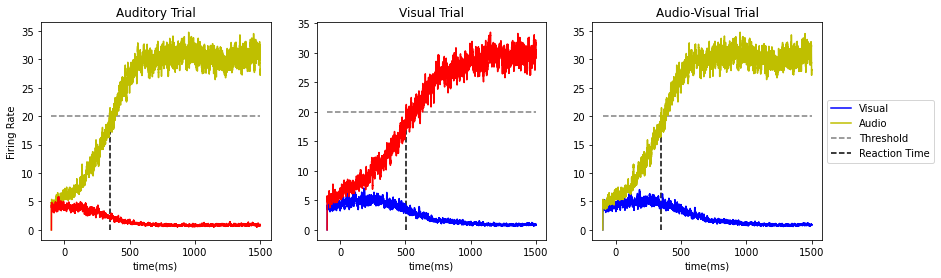

In [64]:
fig = plt.figure(figsize=(14,4))
plt.subplot(131)
plt.plot(time,Firing_target_AUDIO_HIT.T,'y')
plt.plot(time,Firing_target_AUDIO_MISS.T,'r')

plt.hlines(Threshold,-100,1500,colors='grey',linestyles='dashed',label='Threshold')
plt.vlines(RT_AUDIO[-1],0,Threshold,colors='k',linestyles='dashed',label='Reaction Time')
plt.xlabel('time(ms)')
plt.ylabel('Firing Rate')

plt.title("Auditory Trial")
#plt.legend()
plt.subplot(132)
plt.plot(time,Firing_target_VIS_HIT.T,'b')
plt.plot(time,Firing_target_VIS_MISS.T,'r')
plt.hlines(Threshold,-100,1500,colors='grey',linestyles='dashed',label='Threshold')
plt.vlines(RT_VIS[-1],0,Threshold,colors='k',linestyles='dashed',label='Reaction Time')
#plt.legend()
plt.xlabel('time(ms)')
plt.title("Visual Trial")
plt.subplot(133)
plt.plot(time,Firing_target_VIS_HIT.T,'b',label='Visual')
plt.plot(time,Firing_target_AUDIO_HIT.T,'y',label='Audio')
#plt.plot(time,Firing_target_VIS_MISS.T)
plt.hlines(Threshold,-100,1500,colors='grey',linestyles='dashed',label='Threshold')
plt.vlines(RT_AV[-1],0,Threshold,colors='k',linestyles='dashed',label='Reaction Time')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('time(ms)')
plt.title("Audio-Visual Trial")
plt.show()

### Reaction Time
### Individual Example

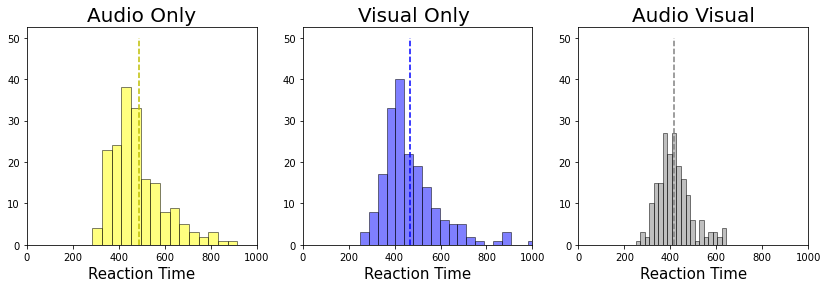

In [68]:
fig = plt.figure(figsize=(14,4))
plt.subplot(132)
plt.hist(RT_VIS[ANSWER_VIS==1],bins=20,facecolor='blue', ec="k", alpha=0.5)
plt.vlines(np.mean(RT_VIS[ANSWER_VIS==1]),0,50,linestyles='dashed',color='b')
plt.xlim(0,1000)

plt.xlabel('Reaction Time',fontsize=15)
plt.title('Visual Only ',fontsize=20)


plt.subplot(131)
plt.hist(RT_AUDIO[ANSWER_AUDIO==1],bins=20,facecolor='yellow', ec="k", alpha=0.5)
plt.xlabel('Reaction Time',fontsize=15)
plt.vlines(np.mean(RT_AUDIO[ANSWER_AUDIO==1]),0,50,linestyles='dashed',color='y')
plt.xlim(0,1000)



plt.title('Audio Only',fontsize=20)


plt.subplot(133)
plt.hist(RT_AV[ANSWER_AV==1],bins=20,facecolor='grey', ec="k", alpha=0.5)
plt.vlines(np.mean(RT_AV[ANSWER_AV==1]),0,50,color='grey',linestyles='dashed',label="Mean Reaction Time")
plt.xlabel('Reaction Time',fontsize=15)
plt.title('Audio Visual',fontsize=20)
plt.xlim(0,1000)
plt.show()

### Group Analysis

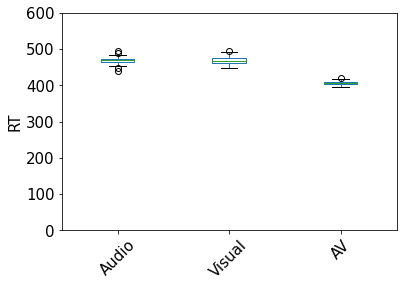

In [17]:
df=pd.DataFrame({'Audio': GROUP_RT[0,:], 'Visual': GROUP_RT[1,:],'AV':GROUP_RT[2,:]})

fig = plt.figure(figsize=(6,4))
ax=df.boxplot(grid=False, rot=45, fontsize=15)
#ax=df.plot.scatter()
#fig.set_ylabel('RT')
ax.set_ylabel('RT', fontsize=15)
ax.set_ylim((0,600))
#df.boxplot(grid=False, rot=45, fontsize=15)
plt.show()


### ACCURACY 

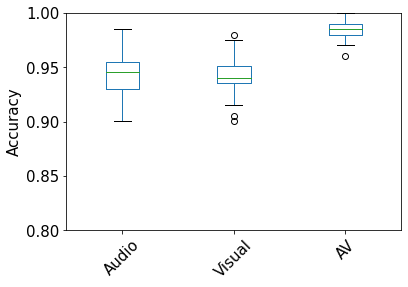

In [65]:
df_ACC=pd.DataFrame({'Audio': GROUP_ACC[0,:], 'Visual': GROUP_ACC[1,:],'AV':GROUP_ACC[2,:]})
#from matplotlib import pyplot as plt

fig = plt.figure(figsize=(6,4))
ax=df_ACC.boxplot(grid=False, rot=45, fontsize=15)
#ax=df.plot.scatter()
#fig.set_ylabel('RT')
ax.set_ylabel('Accuracy', fontsize=15)
plt.ylim(0.8,1)
#df.boxplot(grid=False, rot=45, fontsize=15)
plt.show()



## DDM Results
## Drift Rate

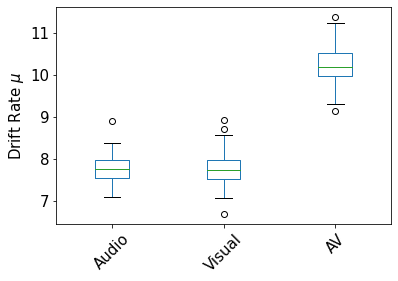

In [44]:
df_Drift=pd.DataFrame({'Audio': A_Drift, 'Visual': V_Drift,'AV':AV_Drift})
#from matplotlib import pyplot as plt

fig = plt.figure(figsize=(6,4))
ax=df_Drift.boxplot(grid=False, rot=45, fontsize=15)
#ax=df.plot.scatter()
#fig.set_ylabel('RT')
ax.set_ylabel(r'Drift Rate $\mu$', fontsize=15)
#df.boxplot(grid=False, rot=45, fontsize=15)
plt.show()


### Time Delay

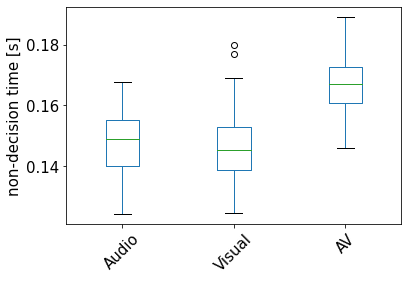

In [66]:

df_delay=pd.DataFrame({'Audio': A_time_delay, 'Visual': V_time_delay,'AV':AV_time_delay})
#from matplotlib import pyplot as plt

fig = plt.figure(figsize=(6,4))
ax=df_delay.boxplot(grid=False, rot=45, fontsize=15)
#ax=df.plot.scatter()
#fig.set_ylabel('RT')
ax.set_ylabel('non-decision time [s]', fontsize=15)
#df.boxplot(grid=False, rot=45, fontsize=15)
plt.show()


### Observed and Predicted

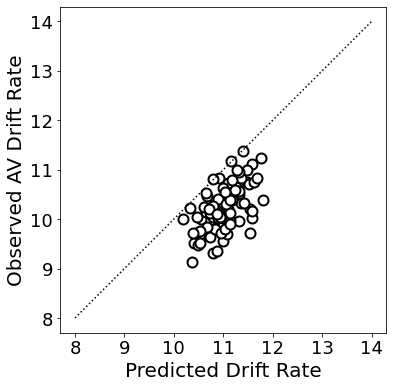

In [52]:
fig = plt.figure(figsize=(6,6))
plt.plot(Pred_Drift,AV_Drift,'ko',markeredgewidth=2,markerfacecolor='white', markersize=10)
plt.plot([8,14],[8,14],'k:')
plt.ylabel('Observed AV Drift Rate',fontsize=20)
plt.xlabel('Predicted Drift Rate',fontsize=20)
plt.xlim(8,14)
plt.ylim(8,14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axis('square')
plt.show()

In [33]:
RT_melt = pd.melt(df_RT  g .reset_index(), id_vars=['index'], value_vars=['Audio', 'Visual', 'AV'])
# replace column names
RT_melt.columns = ['index', 'condition', 'RT']


# Ordinary Least Squares (OLS) model
model = ols('RT ~ C(condition)', data=RT_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(condition),249557.227464,2.0,2073.273408,3.284455e-175
Residual,17874.752135,297.0,NaN,NaN


In [37]:
ACC_melt = pd.melt(df_ACC.reset_index(), id_vars=['index'], value_vars=['Audio', 'Visual', 'AV'])
# replace column names
ACC_melt.columns = ['index', 'condition', 'ACC']


# Ordinary Least Squares (OLS) model
model = ols('ACC ~ C(condition)', data=ACC_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(condition),0.124769,2.0,329.770738,3.713791e-76
Residual,0.056185,297.0,NaN,NaN


In [45]:

Drift_melt = pd.melt(df_Drift.reset_index(), id_vars=['index'], value_vars=['Audio', 'Visual', 'AV'])
# replace column names
Drift_melt.columns = ['index', 'condition', 'Drift']

# Ordinary Least Squares (OLS) model
model = ols('Drift ~ C(condition)', data=Drift_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(condition),401.162589,2.0,1337.265239,2.929373e-149
Residual,44.548114,297.0,NaN,NaN


In [46]:

Delay_melt = pd.melt(df_delay.reset_index(), id_vars=['index'], value_vars=['Audio', 'Visual', 'AV'])
# replace column names
Delay_melt.columns = ['index', 'condition', 'Delay']

# Ordinary Least Squares (OLS) model
model = ols('Delay ~ C(condition)', data=Delay_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(condition),0.025909,2.0,122.592487,1.525571e-39
Residual,0.031384,297.0,NaN,NaN


## Reference
Fearon, C., Butler, J. S., Newman, L., Lynch, T., & Reilly, R. B. (2015). Audiovisual processing is abnormal in Parkinson’s disease and correlates with freezing of gait and disease duration. Journal of Parkinson's disease, 5(4), 925-936.

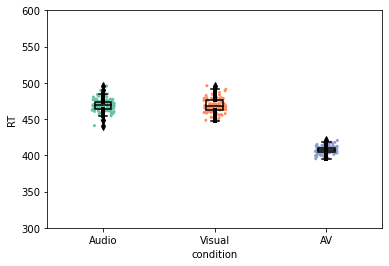

In [57]:
fig, ax = plt.subplots()
pal = "Set2"
ax=sns.stripplot( x = "condition", y = "RT", data = RT_melt, palette = pal,
edgecolor = "white", size = 3, jitter = 1, zorder = 0)
ax=sns.boxplot( x = "condition", y = "RT", data = RT_melt, color = "black",
width = .15, zorder = 10, showcaps = True,
boxprops = {'facecolor':'none', "zorder":10}, showfliers=True, whiskerprops = {'linewidth':4, "zorder":10},
saturation = 1)
ax.set_ylim(300,600)
plt.show()

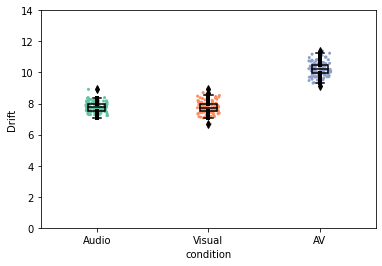

In [51]:
fig, ax = plt.subplots()
pal = "Set2"
ax=sns.stripplot( x = "condition", y = "Drift", data = Drift_melt, palette = pal,
edgecolor = "white", size = 3, jitter = 1, zorder = 0)
ax=sns.boxplot( x = "condition", y = "Drift", data = Drift_melt, color = "black",
width = .15, zorder = 10, showcaps = True,
boxprops = {'facecolor':'none', "zorder":10}, showfliers=True, whiskerprops = {'linewidth':4, "zorder":10},
saturation = 1)
ax.set_ylim(0,14)
plt.show()

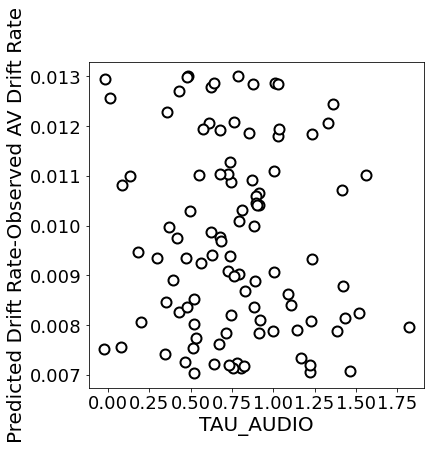

In [56]:
fig = plt.figure(figsize=(6,6))
plt.plot(Pred_Drift-AV_Drift,TAU_AUDIO,'ko',markeredgewidth=2,markerfacecolor='white', markersize=10)
#plt.plot([8,14],[8,14],'k:')
plt.ylabel('Predicted Drift Rate-Observed AV Drift Rate',fontsize=20)
plt.xlabel('TAU_AUDIO',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()